# Examine Assay Matrix Distributions

When employing TReNA, we are applying a solver to an assay matrix to infer relationships between transcription factors and target genes. Both the solver type and the assay matrix are mutable entities; there are currently 6 different solvers built into TReNA. The assay matrix can also be transformed in various ways. In this notebook, we will examine these two variables in an attempt to answer the following questions:

1. How do the different solvers compare to one another on the same data?
2. What is the effect of transforming the assay matrix in different ways?

To this end, we will be using the ampAD data of 154 transcription factors and 278 samples, with MEF2C as the target gene. Our three solvers will be LASSO, Random Forest, and Bayes Spike. The 4 different data transformations we will apply here are: as-is (unchanged), log2-transformed, asinh-transformed, and voom-transformed. 

## Details on the Data

For this exercise, we will be using RNAseq data gathered for Alzheimer's disease (AD) and related diseases [Original Paper Here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5058336/). These expression data are from samples taken during brain autopsies from 4 groups of subjects:
1. Normal/control group, with no discernable cognitive impairment and no diagnosis of any neurodegnerative disease
2. AD group, with cognitive impairment and a diagnosis of AD
3. Progressive supranuclear palsy (PSP) group, with cognitive impairment and a diagnosis of PSP
4. Pathelogical aging, with the presence of amyloid plaques associated with a diseased state, but with no discernible cognitive impairment. 

MEF2C is a gene identified through genome-wide association studies to be associated with protection from AD. To better understand which transcription factors are associated with MEF2C, and thus may be associated with AD, we will use TReNA to identify meaningful relationships. 

## Transformation Characteristics

Let us first get a handle on what our data look like under the 4 different transformations. 

1. The "as-is" data are fairly straightforward; we have RNAseq data in units of RPKM with expression levels concentrated near 0, but the range of the data is quite large. This skewed dataset may not be ideal (though we don't exactly have a standard to compare to), so one way to adjust that skewed nature is to do a log2 transformation.

2. For each value in the matrix, the log2 transformation subtracts the minimum expression value in the matrix, adds a very small number (0.001) to prevent any attempt at taking log2(0), and then takes log2() of the value. As a result, the log2-transformed data have a much smaller range and appear much more Gaussian than the as-is data. They also cross over 0 into the negative range, a characteristic that differs from the original data.  

3. The third data transformation is using asinh, the hyperbolic arcsine function. The actual math here is to simply take asinh() of every value in the matrix; the resulting distribution is scaled down, much like the log2-transformed data, but all values are positive. 

4. The fourth and final transformation is VOOM transformation, a technique that estimates the mean-variance relationship in the data and uses it to weigh each observation. The transformation is performed using the *voom()* function in the *limma* package from Biocondutor, which is documented [here](http://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf). The manuscript for the VOOM transformation can be found [here](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2014-15-2-r29). 

For a better understanding of what these distributions look like, we can look at histograms of all 3:

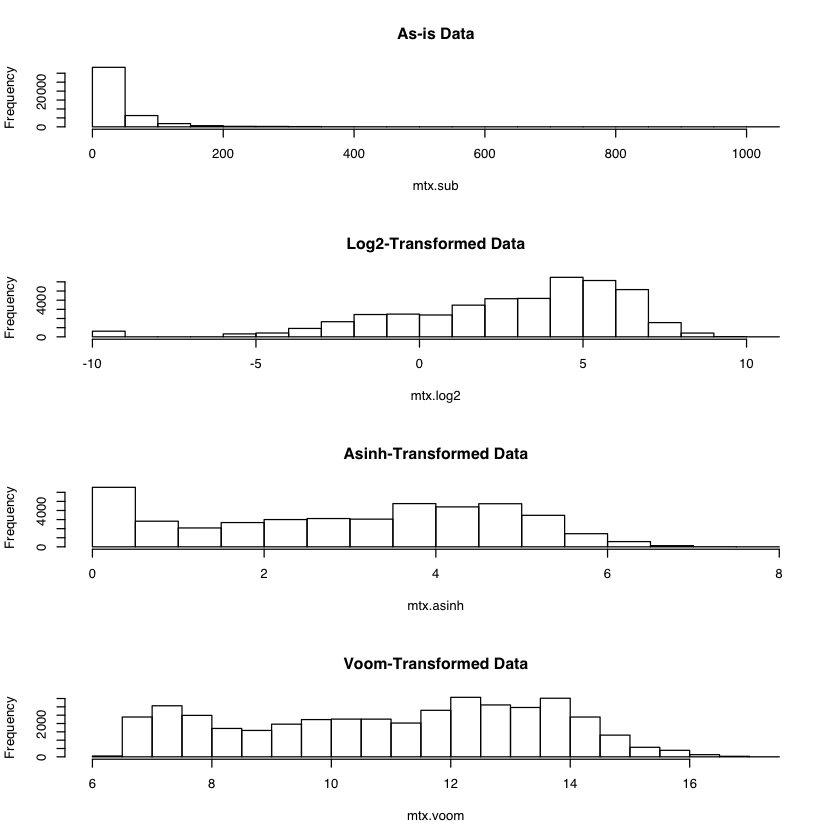

In [3]:
# Load the assay matrix (mtx.sub) and transform it 3 ways
load("../extdata/ampAD.154genes.mef2cTFs.278samples.RData")

mtx.tmp <- mtx.sub - min(mtx.sub) + 0.001
mtx.log2 <- log2(mtx.tmp)

mtx.asinh <- asinh(mtx.sub)

suppressMessages(library(limma))
mtx.voom <- voom(mtx.sub)$E

# Plot them all
par(mfrow = c(4,1))
par(family = "sans")
hist(mtx.sub, main = "As-is Data")
hist(mtx.log2, main = "Log2-Transformed Data")
hist(mtx.asinh, main = "Asinh-Transformed Data")
hist(mtx.voom, main = "Voom-Transformed Data")

The data distributions are quite dissimilar, so it follows that we might expect different results when using them, even if we're using the same solver. To explicitly quantify these distributions, we can also take Tukey's five number summary (min,1st quartile, median, 3rd quartile, max) of each one:

In [4]:
cat("As-is :",fivenum(mtx.sub),"\n")
cat(" Log2 :",fivenum(mtx.log2),"\n")
cat("Asinh :",fivenum(mtx.asinh),"\n")
cat(" Voom :",fivenum(mtx.voom),"\n")

As-is : 0 1.753137 12.34697 43.24747 1027.766 
 Log2 : -9.965784 0.8107618 3.626201 5.434577 10.0053 
Asinh : 0 1.327453 3.208193 4.460219 7.62829 
 Voom : 6.379003 8.825687 11.33609 13.10218 17.47137 


As we expected, the as-is data have a much wider distribution but are concentrated around small values. The log2 and asinh data both scale down the distribution in different ways, with the log2 transformation incoporating negative values and the asinh transformation finding its minimum at 0. 

Now that we've examined the distributions fairly thoroughly, let us move to using the solvers themselves to infer relationships between transcription factors and target genes. This will give us a better idea of how our distributions affect the solutions we infer and what we might want to be careful of in the future

## Testing Distributions and Solvers in TReNA

First things first, we'll go ahead and load our function; this function will do several things:

1. Load the "as-is" data and create the 3 different matrices we've examined above
2. For each of those 3 matrices, create and solve a TReNA object for each of 4 solvers (LASSO, Bayes Spike, Random Forest, Square Root LASSO) with MEF2C as the target gene. This means we'll have 12 total solutions. 
3. For each of the 12 solutions, pull out the top 10 genes, then take the union of those 9 sets of 10. This will give us a list of genes representing the best hits for each combination of distribution and solver
3. Compile the scores of those genes from the 12 solutions into a unified table (tbl.all), along with the gene names and their Pearson correlations to MEF2C.

Let's do that and produce our table.

In [2]:
# Source the desired function and generate the table
suppressMessages(source("../utils/evaluateAllSolvers.R"))
tbl.all <- assess_ampAD154AllSolversAndDistributions()

[1] --- Testing LASSO
[1] --- Testing Bayes Spike
[1] --- Testing Random Forest
[1] --- Testing Square Root LASSO


Just to get an idea of what we're looking at, here's the table. We can browse through this to see what the data look like. 

In [3]:
tbl.all

,gene,lasso.as.is,lasso.log2,lasso.asinh,lasso.voom,bs.as.is,bs.log2,bs.asinh,bs.voom,rf.as.is,rf.log2,rf.asinh,rf.voom,sqrt.lasso.as.is,sqrt.lasso.log2,sqrt.lasso.asinh,sqrt.lasso.voom,gene.cor
9,HLF,0.7928153980,0.1384401040,0.161128298,2.430766e-01,5.521017e-01,1.043135e-04,4.901143e-01,4.034071e-01,1323631.3413,58.51999921,25.94633653,47.63993000,0.69519133,0.140776460,0.142896092,0.15897283,0.92323940
4,STAT4,2.7234147543,0.1516976381,0.122715345,9.313344e-02,1.425384e+00,1.264903e-04,2.152613e-01,2.497628e-01,699501.1417,44.28709967,20.18357810,52.30225007,3.47937884,0.190961358,0.158960329,0.17336532,0.90475987
41,SATB1,0.0000000000,0.0000000000,0.000000000,0.000000e+00,-3.111620e-02,-2.566937e-05,8.229178e-06,2.235164e-05,543077.0110,20.58020726,10.91982880,31.20690215,0.00000000,0.000000000,0.000000000,0.00000000,0.86282704
16,SATB2,0.1170162587,0.2186880650,0.234497327,2.636667e-01,9.471114e-01,5.762971e-01,6.273711e-05,2.727977e-02,409038.6540,25.79571095,14.39239773,32.42462538,0.02139235,0.181298914,0.226526723,0.23814460,0.84232989
42,ATF2,0.0000000000,0.0000000000,0.000000000,0.000000e+00,3.420941e-02,5.664688e-05,7.898445e-06,-7.151110e-06,145338.8910,4.76926440,1.84008858,5.68379652,0.08809962,0.008485763,0.000000000,0.00000000,0.82786857
5,FOXP2,2.5415262709,0.1075454813,0.119451957,1.319753e-01,4.484311e+00,2.117807e-04,2.794435e-05,2.000704e-02,142055.2075,5.94845257,3.48425613,4.97870097,2.44496515,0.101105760,0.106358127,0.10469561,0.81961721
11,TSHZ2,0.6712651520,0.1063925230,0.100165781,9.804753e-02,9.562624e-02,1.646563e-01,2.269360e-01,1.802648e-01,54312.4522,5.03171167,1.98027966,4.70787427,1.00207756,0.100506784,0.094864545,0.08923052,0.77043615
44,DRGX,0.0000000000,0.0000000000,0.000000000,0.000000e+00,1.126113e-01,9.920570e-06,2.175109e-05,6.762244e-05,53419.7183,7.65093418,3.67082828,8.68218844,1.18904754,0.000000000,0.000000000,0.00000000,0.73094500
1,HDX,11.1120492315,0.0000000000,0.000000000,0.000000e+00,5.143928e+00,7.616355e-06,5.801534e-05,2.069076e-05,62934.0332,1.32430235,0.55013068,1.00870594,13.37342127,0.000000000,0.000000000,0.00000000,0.72419056
8,LHX6,1.3312683030,0.0653839268,0.080111870,9.669643e-02,1.188259e-01,1.581145e-01,3.358203e-04,7.119389e-05,24628.7044,3.74391264,1.70679111,2.88959162,2.69414714,0.058348346,0.086557473,0.09288872,0.71461154


In [4]:
dim(tbl.all)

[1] 45 18

As we can see here, the union of top 10 genes from all solutions results in 45 genes. We can see that both LASSO methods are behaving much as we'd expect them, with some coefficients being shrunken to 0. We can see a little of what's going on with the scores in general--Random Forest looks to line up with itself regardless of distribution, whereas the others do not--but rather than draw conclusions based on a cursory look, let's examine the correlations more closely. 

### A Broad view

We'll take a look at the correlations between all different columns to give us a broad look at our table. We'll output these correlations as a plot of pairwise correlations. 

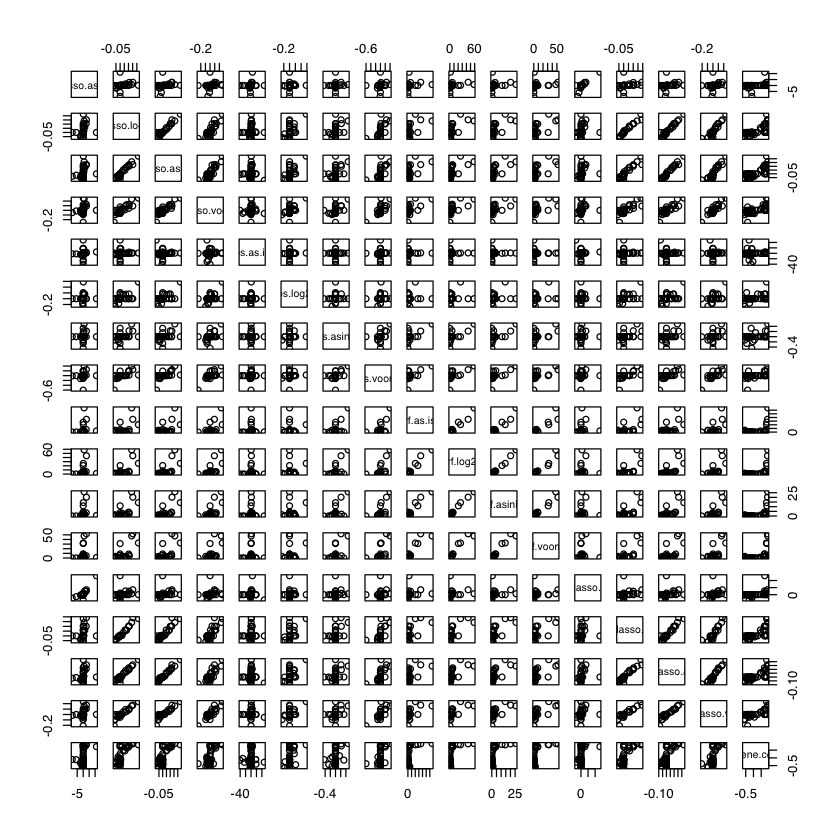

In [7]:
# Plot all pairs
par(family = "sans")
pairs(tbl.all[2:18],
     labels = names(tbl.all)[2:18])

A few things stand out here; first of all, the 4 different Random Forest distributions and the 4 different Square Root LASSO distributions look to be in very good agreement, producing the linear plots found near the bottom right corner. The other 2 solvers don't show nearly the same level of correlation between different distributions, though LASSO looks at least somewhat similar when comparing the log2 and asinh data. When it comes to the gene correlations themselves, LASSO looks to be the most similar, particularly for the asinh- transformed case.

This broad view can clue us in to some trends, but it's likely that we'll get much better resolution by looking more directly at smaller pieces of the data. Let us now zoom in to look more closely at how the different cases compare. We'll begin by looking at how different distributions affect results within the same solver, then shift to how different solvers affect results within the same distribution. 

### Within-Solver Trends

We are interested in the question: how does transforming the data affect the correlations between genes? We'll look at the top genes found by the solvers, sorted by their Pearson correlation with the target gene. First, let's look at LASSO:

In [8]:
head(tbl.all[,c(1,2,3,4,5,18)],10)

,gene,lasso.as.is,lasso.log2,lasso.asinh,lasso.voom,gene.cor
9,HLF,0.7928154,0.13844010,0.16112830,0.24307664,0.9232394
4,STAT4,2.7234148,0.15169764,0.12271535,0.09313344,0.9047599
41,SATB1,0.0000000,0.00000000,0.00000000,0.00000000,0.8628270
16,SATB2,0.1170163,0.21868807,0.23449733,0.26366669,0.8423299
42,ATF2,0.0000000,0.00000000,0.00000000,0.00000000,0.8278686
5,FOXP2,2.5415263,0.10754548,0.11945196,0.13197534,0.8196172
11,TSHZ2,0.6712652,0.10639252,0.10016578,0.09804753,0.7704362
44,DRGX,0.0000000,0.00000000,0.00000000,0.00000000,0.7309450
1,HDX,11.1120492,0.00000000,0.00000000,0.00000000,0.7241906
8,LHX6,1.3312683,0.06538393,0.08011187,0.09669643,0.7146115


As we would expect from LASSO, many genes are missing coefficients because they've been shrunken out of the model. What we wouldn't necessarily expect is that the remaining coefficients don't necessarily line up well with one another. To quantify that, let us compare the LASSO coefficients between transformation types.

In [9]:
# For each pairwise comparison, find correlation
cor(tbl.all[2:5])

,lasso.as.is,lasso.log2,lasso.asinh,lasso.voom
lasso.as.is,1.0000000,0.1945695,0.2300450,0.1817978
lasso.log2,0.1945695,1.0000000,0.9618035,0.8371368
lasso.asinh,0.2300450,0.9618035,1.0000000,0.8762928
lasso.voom,0.1817978,0.8371368,0.8762928,1.0000000


Correlation between the coefficients found for the "as-is" data with either transformed data type aren't particularly high, but transformed matrices are in much better agreement. We can similarly look at the results from using Bayes Spike as the solver:

In [11]:
head(tbl.all[,c(1,6:9,18)],10)

,gene,bs.as.is,bs.log2,bs.asinh,bs.voom,gene.cor
9,HLF,0.55210175,1.043135e-04,4.901143e-01,4.034071e-01,0.9232394
4,STAT4,1.42538426,1.264903e-04,2.152613e-01,2.497628e-01,0.9047599
41,SATB1,-0.03111620,-2.566937e-05,8.229178e-06,2.235164e-05,0.8628270
16,SATB2,0.94711144,5.762971e-01,6.273711e-05,2.727977e-02,0.8423299
42,ATF2,0.03420941,5.664688e-05,7.898445e-06,-7.151110e-06,0.8278686
5,FOXP2,4.48431142,2.117807e-04,2.794435e-05,2.000704e-02,0.8196172
11,TSHZ2,0.09562624,1.646563e-01,2.269360e-01,1.802648e-01,0.7704362
44,DRGX,0.11261125,9.920570e-06,2.175109e-05,6.762244e-05,0.7309450
1,HDX,5.14392771,7.616355e-06,5.801534e-05,2.069076e-05,0.7241906
8,LHX6,0.11882588,1.581145e-01,3.358203e-04,7.119389e-05,0.7146115


From visual inspection, these coefficients are a bit all over the map in terms of magnitude and sign. Additionally, most of the coefficients for the log-transformed, and many from the asinh-transformed, are quite small. Let's look at these correlations:

In [12]:
cor(tbl.all[6:9])

,bs.as.is,bs.log2,bs.asinh,bs.voom
bs.as.is,1.000000000,0.02193727,0.009409688,0.02632733
bs.log2,0.021937265,1.00000000,0.096921052,0.10419688
bs.asinh,0.009409688,0.09692105,1.000000000,0.41325621
bs.voom,0.026327329,0.10419688,0.413256209,1.00000000


There appears to be very little agreement between the as-is Bayes Spike coefficients and the other transformations, but there's some agreement in the asinh and voom transformed datasets. This is somewhat similar to what we saw for the LASSO solver, though all correlations for the Bayes Spike coefficients are weaker. 

Let's continue our survey of the solvers by looking at the Random Forest scores:

In [15]:
head(tbl.all[,c(1,10:13,18)],10)

,gene,rf.as.is,rf.log2,rf.asinh,rf.voom,gene.cor
9,HLF,1323631.34,58.519999,25.9463365,47.639930,0.9232394
4,STAT4,699501.14,44.287100,20.1835781,52.302250,0.9047599
41,SATB1,543077.01,20.580207,10.9198288,31.206902,0.8628270
16,SATB2,409038.65,25.795711,14.3923977,32.424625,0.8423299
42,ATF2,145338.89,4.769264,1.8400886,5.683797,0.8278686
5,FOXP2,142055.21,5.948453,3.4842561,4.978701,0.8196172
11,TSHZ2,54312.45,5.031712,1.9802797,4.707874,0.7704362
44,DRGX,53419.72,7.650934,3.6708283,8.682188,0.7309450
1,HDX,62934.03,1.324302,0.5501307,1.008706,0.7241906
8,LHX6,24628.70,3.743913,1.7067911,2.889592,0.7146115


This looks a lot more in line with what we would expect; the Random Forest scores look to decrease in size almost monotonically along with the Pearson correlations. Furthermore, they look to do so regardless of whether or not the data have been transformed, although the coefficient sizes vary quite a bit. Let's follow up with the correlations between different transformations.

In [16]:
cor(tbl.all[10:13])

,rf.as.is,rf.log2,rf.asinh,rf.voom
rf.as.is,1.0000000,0.9732578,0.9630117,0.9261020
rf.log2,0.9732578,1.0000000,0.9951547,0.9720745
rf.asinh,0.9630117,0.9951547,1.0000000,0.9815181
rf.voom,0.9261020,0.9720745,0.9815181,1.0000000


The correlation coefficients between matrix types suggests very high agreement in all cases, and nearly identical trends when using log-transformed and asinh-transformed data. This is important information as we think about using Random Forest on other datasets; we can likely expect that regardless of transformation, we'll likely find similar results. 

Let's finish our survey of solvers by looking at Square Root LASSO:

In [17]:
head(tbl.all[,c(1,14:17,18)],10)

,gene,sqrt.lasso.as.is,sqrt.lasso.log2,sqrt.lasso.asinh,sqrt.lasso.voom,gene.cor
9,HLF,0.69519133,0.140776460,0.14289609,0.15897283,0.9232394
4,STAT4,3.47937884,0.190961358,0.15896033,0.17336532,0.9047599
41,SATB1,0.00000000,0.000000000,0.00000000,0.00000000,0.8628270
16,SATB2,0.02139235,0.181298914,0.22652672,0.23814460,0.8423299
42,ATF2,0.08809962,0.008485763,0.00000000,0.00000000,0.8278686
5,FOXP2,2.44496515,0.101105760,0.10635813,0.10469561,0.8196172
11,TSHZ2,1.00207756,0.100506784,0.09486455,0.08923052,0.7704362
44,DRGX,1.18904754,0.000000000,0.00000000,0.00000000,0.7309450
1,HDX,13.37342127,0.000000000,0.00000000,0.00000000,0.7241906
8,LHX6,2.69414714,0.058348346,0.08655747,0.09288872,0.7146115


Much like regular LASSO, we see many coefficients shrunken to 0 and there seems to be good agreement in which coefficients are 0 in the transformed cases, particularly between the asinh and voom transformations. We'll look at the correlations to get a better look

In [18]:
cor(tbl.all[14:17])

,sqrt.lasso.as.is,sqrt.lasso.log2,sqrt.lasso.asinh,sqrt.lasso.voom
sqrt.lasso.as.is,1.0000000,0.1880867,0.2256798,0.1992901
sqrt.lasso.log2,0.1880867,1.0000000,0.9593382,0.9133527
sqrt.lasso.asinh,0.2256798,0.9593382,1.0000000,0.9493018
sqrt.lasso.voom,0.1992901,0.9133527,0.9493018,1.0000000


The as-is coefficients don't really line up with the others, but all 3 transformations are in close agreement here. 


## Inspect Trends Between Solvers

From looking at the within-solvers comparisons, it seems evident that we can probably expect some major differences between solver types. Let's look first at the as-is data across solvers; we'll look at the columns in a table and compute the correlation coefficients concurrently.

In [19]:
head(tbl.all[,c(1,2,6,10,14,18)],10)
cor(tbl.all[c(2,6,10,14,18)])

,gene,lasso.as.is,bs.as.is,rf.as.is,sqrt.lasso.as.is,gene.cor
9,HLF,0.7928154,0.55210175,1323631.34,0.69519133,0.9232394
4,STAT4,2.7234148,1.42538426,699501.14,3.47937884,0.9047599
41,SATB1,0.0000000,-0.03111620,543077.01,0.00000000,0.8628270
16,SATB2,0.1170163,0.94711144,409038.65,0.02139235,0.8423299
42,ATF2,0.0000000,0.03420941,145338.89,0.08809962,0.8278686
5,FOXP2,2.5415263,4.48431142,142055.21,2.44496515,0.8196172
11,TSHZ2,0.6712652,0.09562624,54312.45,1.00207756,0.7704362
44,DRGX,0.0000000,0.11261125,53419.72,1.18904754,0.7309450
1,HDX,11.1120492,5.14392771,62934.03,13.37342127,0.7241906
8,LHX6,1.3312683,0.11882588,24628.70,2.69414714,0.7146115


,lasso.as.is,bs.as.is,rf.as.is,sqrt.lasso.as.is,gene.cor
lasso.as.is,1.00000000,0.09297557,0.1612123,0.82322537,0.3468071
bs.as.is,0.09297557,1.00000000,0.0321962,-0.06575482,0.0340242
rf.as.is,0.16121226,0.03219620,1.0000000,0.13861819,0.5108958
sqrt.lasso.as.is,0.82322537,-0.06575482,0.1386182,1.00000000,0.3942769
gene.cor,0.34680708,0.03402420,0.5108958,0.39427692,1.0000000


As we might expect, the 2 LASSO variations have the highest correlation, but otherwise there's not very good agreement between solvers. In terms of the gene correlations themselves, the Random Forest solver has the strongest agreement for the "as-is" data matrix, both LASSO variations are a little weaker, and the Bayes Spike shows virtually no correlation with the Pearson coefficients. Let us move on to the transformations to see what differences there are; we'll begin with log2-transformed data.

In [20]:
head(tbl.all[,c(1,3,7,11,15,18)],10)
cor(tbl.all[c(3,7,11,15,18)])

,gene,lasso.log2,bs.log2,rf.log2,sqrt.lasso.log2,gene.cor
9,HLF,0.13844010,1.043135e-04,58.519999,0.140776460,0.9232394
4,STAT4,0.15169764,1.264903e-04,44.287100,0.190961358,0.9047599
41,SATB1,0.00000000,-2.566937e-05,20.580207,0.000000000,0.8628270
16,SATB2,0.21868807,5.762971e-01,25.795711,0.181298914,0.8423299
42,ATF2,0.00000000,5.664688e-05,4.769264,0.008485763,0.8278686
5,FOXP2,0.10754548,2.117807e-04,5.948453,0.101105760,0.8196172
11,TSHZ2,0.10639252,1.646563e-01,5.031712,0.100506784,0.7704362
44,DRGX,0.00000000,9.920570e-06,7.650934,0.000000000,0.7309450
1,HDX,0.00000000,7.616355e-06,1.324302,0.000000000,0.7241906
8,LHX6,0.06538393,1.581145e-01,3.743913,0.058348346,0.7146115


,lasso.log2,bs.log2,rf.log2,sqrt.lasso.log2,gene.cor
lasso.log2,1.0000000,0.5855358,0.6645165,0.9812911,0.7238329
bs.log2,0.5855358,1.0000000,0.2014535,0.5081544,0.4085911
rf.log2,0.6645165,0.2014535,1.0000000,0.7235018,0.5690629
sqrt.lasso.log2,0.9812911,0.5081544,0.7235018,1.0000000,0.7240951
gene.cor,0.7238329,0.4085911,0.5690629,0.7240951,1.0000000


Once again, the 2 LASSO methods are in close agreement, this time agreeing nearly identically. We now also see much stronger agreement between all methods, with correlation coefficients in the 0.5-0.66 range. In contrast to the "as-is", the log2-transformed data demonstrate at least some correlation between each solver and the gene correlation coefficients, though the 2 LASSO methods have the highest coefficients. Now we'll look at the asinh-transformed data

In [21]:
head(tbl.all[,c(1,4,8,12,16,18)],10)
cor(tbl.all[c(4,8,12,16,18)])

,gene,lasso.asinh,bs.asinh,rf.asinh,sqrt.lasso.asinh,gene.cor
9,HLF,0.16112830,4.901143e-01,25.9463365,0.14289609,0.9232394
4,STAT4,0.12271535,2.152613e-01,20.1835781,0.15896033,0.9047599
41,SATB1,0.00000000,8.229178e-06,10.9198288,0.00000000,0.8628270
16,SATB2,0.23449733,6.273711e-05,14.3923977,0.22652672,0.8423299
42,ATF2,0.00000000,7.898445e-06,1.8400886,0.00000000,0.8278686
5,FOXP2,0.11945196,2.794435e-05,3.4842561,0.10635813,0.8196172
11,TSHZ2,0.10016578,2.269360e-01,1.9802797,0.09486455,0.7704362
44,DRGX,0.00000000,2.175109e-05,3.6708283,0.00000000,0.7309450
1,HDX,0.00000000,5.801534e-05,0.5501307,0.00000000,0.7241906
8,LHX6,0.08011187,3.358203e-04,1.7067911,0.08655747,0.7146115


,lasso.asinh,bs.asinh,rf.asinh,sqrt.lasso.asinh,gene.cor
lasso.asinh,1.0000000,0.3742149,0.6776267,0.9858210,0.7249950
bs.asinh,0.3742149,1.0000000,0.5278433,0.3595720,0.3355313
rf.asinh,0.6776267,0.5278433,1.0000000,0.6916578,0.5915175
sqrt.lasso.asinh,0.9858210,0.3595720,0.6916578,1.0000000,0.7192385
gene.cor,0.7249950,0.3355313,0.5915175,0.7192385,1.0000000


Outside of the expected high agreement between LASSO methods, this transformation also shows fairly strong agreement between Random Forest and the LASSO methods. Bayes Spike is less correlated with the others, but still much more so than in the as-is case. Compared to the gene correlation coefficients, the 2 LASSO methods still show the strongest agreement and Bayes Spike has fallen off a bit. Let's finish by looking at the VOOM-transformed data.

In [22]:
head(tbl.all[,c(1,5,9,13,17,18)],10)
cor(tbl.all[c(5,9,13,17,18)])

,gene,lasso.voom,bs.voom,rf.voom,sqrt.lasso.voom,gene.cor
9,HLF,0.24307664,4.034071e-01,47.639930,0.15897283,0.9232394
4,STAT4,0.09313344,2.497628e-01,52.302250,0.17336532,0.9047599
41,SATB1,0.00000000,2.235164e-05,31.206902,0.00000000,0.8628270
16,SATB2,0.26366669,2.727977e-02,32.424625,0.23814460,0.8423299
42,ATF2,0.00000000,-7.151110e-06,5.683797,0.00000000,0.8278686
5,FOXP2,0.13197534,2.000704e-02,4.978701,0.10469561,0.8196172
11,TSHZ2,0.09804753,1.802648e-01,4.707874,0.08923052,0.7704362
44,DRGX,0.00000000,6.762244e-05,8.682188,0.00000000,0.7309450
1,HDX,0.00000000,2.069076e-05,1.008706,0.00000000,0.7241906
8,LHX6,0.09669643,7.119389e-05,2.889592,0.09288872,0.7146115


,lasso.voom,bs.voom,rf.voom,sqrt.lasso.voom,gene.cor
lasso.voom,1.0000000,0.6991422,0.5819727,0.8934261,0.6214693
bs.voom,0.6991422,1.0000000,0.5013426,0.7341090,0.4167989
rf.voom,0.5819727,0.5013426,1.0000000,0.6414132,0.5859544
sqrt.lasso.voom,0.8934261,0.7341090,0.6414132,1.0000000,0.6754960
gene.cor,0.6214693,0.4167989,0.5859544,0.6754960,1.0000000


In this case, we see the strongest overall agreement between solvers. This is mainly driven by heightened correlation between Bayes Spike and the other methods. The two LASSO methods still have the highest agreement with the Pearson correlations between target gene and transcription factors, but they are not as strong as in the other transformations. 

At this point, we've delved into a whole bunch of information and pulled out lots of correlations between the different transformations, different solvers, and the gene correlations coefficients. So let's step back and sum up what we've seen.

## Takeaways

Based upon this short data exploration, there are a few key points to take away:

1. Data transformation can profoundly affect results. There is no guarantee of consistency across different transformations, even for the same solvers. Furthermore, different transformations can affect which solvers agree with one another. 

2. Random Forest scores are the most consistent across different transformations, so the distribution of the data may be less of a concern if using this solver. LASSO and Square Root LASSO also show strong agreement between the transformed cases, but not compared to the as-is data.

3. Regardless of transformation, LASSO coefficients and Random Forest scores tend to have stronger correlation with gene correlations than do Bayes Spike coefficients.

Though it is tempting to recommend a particular solver and/or transformation to use in every case, this is not a realistic outcome of the exploration done here. Rather, these data should serve as an example of the benefits and consequences involved with these choices, as we have demonstrated that choice of solver and transformation have a sizable impact on the final results.

Perhaps the best summation of this foray into different transformations is found in the [VOOM paper itself](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2014-15-2-r29):

"...correct modeling of the mean-variance relationship inherent in a data generating process is the key to designing statistically powerful methods of analysis."

Thus, transformation techniques such as VOOM that take into account the mean-variance relationship represent a standard way for preparing robust data for use in tools such as TReNA.